In [42]:
# импортируем библиотеки
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# выставляем размер шрифта подписей осей ко всем графикам
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 

In [43]:
# импортируем из другого Jupyter Notebook формулы для решения прямой задачи
%run ./FP_formulas.ipynb

# Задача

In [98]:
# считываем файл
path = "C:\\Users\\vdvor\\Desktop\\art_well_data.txt"

data_file = open(path, "r")   # открываю файл, считаваю содержимое
contents = data_file.read()
data_file.close()

In [99]:
# парсим файл
all_strings = contents.split("\n")
print('количество отсчетов в скважине:', len(all_strings) - 1)

cal_prop = []
dol_prop = []
anh_prop = []
ill_prop = []
por_prop = []

for i in range(1, len(all_strings)):
    
    one_string = all_strings[i].split("\t")
    
    cal_prop.append(int(one_string[0]))
    dol_prop.append(int(one_string[1]))
    anh_prop.append(int(one_string[2]))
    ill_prop.append(int(one_string[3]))
    por_prop.append(int(one_string[4]))
    
index = np.arange(len(all_strings) - 2)
depth = np.arange(3061, 3061 + len(cal_prop), 1)

количество отсчетов в скважине: 40


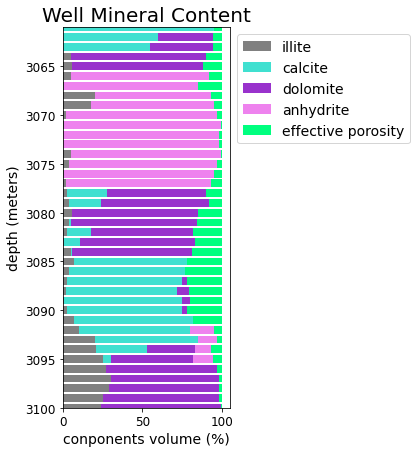

In [100]:
# рисуем график

cal = np.array(cal_prop)
dol = np.array(dol_prop)
anh = np.array(anh_prop)
ill = np.array(ill_prop)
por = np.array(por_prop)

turquoise = '#40E0D0'
dark_violet = '#9932CC'
violet = '#EE82EE'
spring_green = '#00FF7F'

plt.figure(figsize = (3, 7))
plt.title('Well Mineral Content', fontsize = 20)

plt.barh(depth, ill, color = 'grey')
plt.barh(depth, cal, color = turquoise, left = ill)
plt.barh(depth, dol, color = dark_violet, left = cal + ill)
plt.barh(depth, anh, color = violet, left = dol + cal + ill)
plt.barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
plt.xlabel('conponents volume (%)', fontsize = 14)
plt.ylabel('depth (meters)', fontsize = 14)

plt.ylim(max(depth), min(depth))

plt.legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'effective porosity'], fontsize = 14,
          bbox_to_anchor=(1, 1))

plt.show()

In [101]:
# упругие модули
calcite = [70.8, 30.3]
dolomite = [80.2, 48.8]
anhydrite = [59.1, 31.4]
illite = [25.3, 16.3]

water = [2.496, 0]


# плотности
rho_components = [2.71, 2.87, 2.97, 2.52]

# Решение

## Прямая задача 

In [102]:
def do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_DEM_aspect_moduli,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props, porosity,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по Хашину-Штрикману
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, illite,
                                        cal_dol_anh, proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по Хашину-Штрикману:', cal_dol_anh_ill)

        
    # круглые поры в твердую матрицу по DEM
    asp = 1 # аспектное отношение пор
    inclusions = [0, 0]
    matrix_pores = solveDem(cal_dol_anh_ill, inclusions, asp, porosity)
    #print('4. круглые поры в твердую матрицу по DEM:', matrix_pores)
    

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, water, porosity)
    #print('5. готовая порода после насыщения пор флюидом:', saturated)
    
    # рассчитаем скорости Vp и Vs
    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    rho_fluid = 1 * porosity / 100
    rho = rho_fluid + rho_matrix * (100 - porosity) / 100

    vp, vs = get_velocity(rho, saturated)

    return vp, vs, rho

In [103]:
# находит значения плотности и скоростей Vp и Vs в скважине
def get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop,
                          rho_components = [2.71, 2.87, 2.97, 2.52, 1]):
    
    well_vp = []
    well_vs = []
    well_rho = []
    
    for i in range(len(cal_prop)):
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_sample, vs_sample, rho_sample = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_DEM_aspect_moduli,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props, porosity)
        well_vp.append(vp_sample)
        well_vs.append(vs_sample)
        well_rho.append(rho_sample)
    
    return well_vp, well_vs, well_rho

In [104]:
all_vp, all_vs, all_rho = get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop)

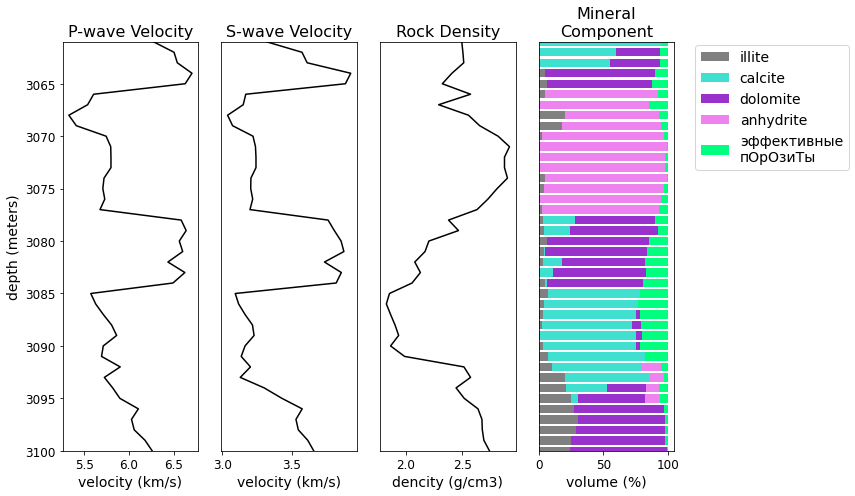

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 7))

axes[3].barh(depth, ill, color = 'grey')
axes[3].barh(depth, cal, color = turquoise, left = ill)
axes[3].barh(depth, dol, color = dark_violet, left = cal + ill)
axes[3].barh(depth, anh, color = violet, left = dol + cal + ill)
axes[3].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
axes[3].set_ylim(bottom = max(depth), top = min(depth))
axes[3].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные\nпОрОзиТы'], fontsize = 14, 
               bbox_to_anchor=(1.1, 1.01))
axes[3].yaxis.set_visible(False)
axes[3].set_title('Mineral\nComponent', fontsize = 16)
axes[3].set_xlabel('volume (%)', fontsize = 14)

axes[0].plot(all_vp, depth, c = 'k')
axes[0].set_ylim(bottom = max(depth), top = min(depth))
axes[0].set_title('P-wave Velocity', fontsize = 16)
axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)

axes[1].plot(all_vs, depth, c = 'k')
axes[1].set_ylim(bottom = max(depth), top = min(depth))
axes[1].yaxis.set_visible(False)
axes[1].set_title('S-wave Velocity', fontsize = 16)
axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

axes[2].plot(all_rho, depth, c = 'k')
axes[2].set_ylim(bottom = max(depth), top = min(depth))
axes[2].yaxis.set_visible(False)
axes[2].set_title('Rock Density', fontsize = 16)
axes[2].set_xlabel('dencity (g/cm3)', fontsize = 14)

fig.tight_layout()

## Обратная задача 

In [106]:
def do_forward_problem_matrix(props,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по Хашину-Штрикману
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, illite,
                                        cal_dol_anh, proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по Хашину-Штрикману:', cal_dol_anh_ill)
        
    # плотность матрицы
    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    return cal_dol_anh_ill, rho_matrix



def do_forward_problem_pores_fast(cal_dol_anh_ill, rho_matrix, porosity):
    # круглые поры в твердую матрицу по DEM
    asp = 1 # аспектное отношение пор
    inclusions = [0, 0]
    matrix_pores = solveDem(cal_dol_anh_ill, inclusions, asp, porosity)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, water, porosity)

    # рассчитаем скорости Vp и Vs
    rho_fluid = 1
    rho = rho_matrix * (1 - porosity/100) + rho_fluid * porosity/100
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)

    return vp, vs, rho

## Монте-Карло 

In [120]:
# вычисляет невязку между исходными и инвертированными значениями скорости,
# на вход подаются исходные (vp_true, vs_true) и инвертированные (vp_sample, vs_sample) значения скорости (type = float),
# а также заранее заданная ошибка allowable error (float)
def check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error):
    error = math.sqrt((vp_true - vp_sample)**2 + (vs_true - vs_sample)**2)
    if error < allowable_error:
        return True
    else:
        return False
    

def do_monte_carlo(cal_dol_anh_ill, rho_matrix, vp_true, vs_true, N, allowable_error, fluid = water):
    
    # создаются пустые массивы, которые будут заполняться инвертированными данными
    vs = []
    vp = []
    good_por = []

    while len(good_por) < N:
        # настреливаются значения пористости по нормальному закону распределения
        por = np.random.normal(loc = 20, scale = 10)
        
        # убираются значения пористости, которые меньше или равны нулю
        if por <= 0:
            por = 20

        vp_sample, vs_sample, rho_sample = do_forward_problem_pores_fast(cal_dol_anh_ill, rho_matrix, por)
        check = check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error)
        
        if check == True:
            good_por.append(por)
    
    avg_por = sum(good_por) / len(good_por)

    return avg_por

In [154]:
from time import time

def do_inverse_problem(cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs, N = 10, allowable_error = 0.1):
    
    all_por = []
    
    start = time()
    for i in range(len(well_vp)):
        
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        cal_dol_anh_ill, rho_matrix = do_forward_problem_matrix(props)
        
        avg_por = do_monte_carlo(cal_dol_anh_ill, rho_matrix, vp_true, vs_true, N, allowable_error)
        
        all_por.append(avg_por)

        
    end = time()
    
    return(all_por, end - start)

In [155]:
all_por, IP_time = do_inverse_problem(cal_prop, dol_prop, anh_prop, ill_prop, all_vp, all_vs)

In [156]:
print('time (s):', IP_time)
print()
print(all_por)

time (s): 107.58834958076477

[5.442722003764489, 5.992069549888847, 6.433458035253009, 10.005585084215445, 12.242182044477218, 8.487707836706988, 14.983719153961687, 7.32534314791725, 5.380043060009707, 3.775153794977176, 1.7735884749291, 1.9172379673456887, 1.9889827144999448, 1.6604113835704908, 3.198905115299434, 5.3765194322739465, 7.31648632346247, 10.2762205592127, 8.476854979964862, 15.350922691637487, 16.10743477120695, 18.239452358243422, 16.95519394189543, 18.61961679433859, 22.083369442562947, 22.570917941865492, 22.140754946398125, 20.4812690560049, 20.139539025355482, 21.842659330918234, 18.294650073673864, 4.771049091748489, 3.209660717269338, 7.695606662283995, 5.79845497419593, 2.999585102007344, 1.7074882077082083, 2.7396381473250506, 2.2238046851456916, 1.3758357573794295]


In [157]:
all_vp_mc, all_vs_mc, all_rho_mc = get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, all_por)

print(all_vp_mc)
print()
print(all_vs_mc)

[6.248165429777602, 6.504981660213081, 6.516169343738616, 6.704998038020162, 6.615297729055247, 5.580754136272245, 5.537701730891249, 5.312153335761314, 5.393314562705483, 5.7082373811155716, 5.760247097195534, 5.801840331746362, 5.798546544476251, 5.690721896528988, 5.697777570863097, 5.710895390057616, 5.66011715200221, 6.568429092302, 6.613558627171632, 6.542536892919587, 6.5947430629549055, 6.421012621883286, 6.628380838365339, 6.516094184773603, 5.566907960234207, 5.654832240039856, 5.702741448546404, 5.8384204578322105, 5.852729125538338, 5.722024775441687, 5.674622461365819, 5.91377195997807, 5.713669279136389, 5.783027981400396, 5.907506052347403, 6.104728584557132, 6.041537654399155, 6.024782215888261, 6.169197359468719, 6.241941501435764]

[3.308520491895214, 3.572695129983527, 3.5984366717406204, 3.921831692017778, 3.8762593589932663, 3.1578766856827096, 3.1512203978729785, 3.0316905615634213, 3.0662735838116117, 3.204277406574397, 3.222526120811315, 3.244071960075544, 3.242

In [158]:
def draw_MC_plots(depth, ill, cal, dol, anh, por, well_vp, well_vs, well_rho, all_vp_mc, all_vs_mc, all_rho_mc, title):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 7))
    fig.suptitle(title, fontsize = 12)

    axes[4].barh(depth, ill, color = 'grey')
    axes[4].barh(depth, cal, color = turquoise, left = ill)
    axes[4].barh(depth, dol, color = dark_violet, left = cal + ill)
    axes[4].barh(depth, anh, color = violet, left = dol + cal + ill)
    axes[4].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
    axes[4].set_ylim(bottom = max(depth), top = min(depth))
    axes[4].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные\nпОрОзиТы'], fontsize = 14, 
                   bbox_to_anchor=(1.1, 1.01))
    axes[4].yaxis.set_visible(False)
    axes[4].set_title('Mineral\nComponent', fontsize = 15)
    axes[4].set_xlabel('volume (%)', fontsize = 13)

    axes[0].plot(well_vp, depth, c = 'k')
    axes[0].plot(all_vp_mc, depth, c = 'r', linestyle = '--')
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave Velocity', fontsize = 15)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 13)
    axes[0].set_ylabel('depth (meters)', fontsize = 13)
    axes[0].legend(['forward modeling', 'inverse modeling'], fontsize = 14, bbox_to_anchor=(7.53, 0.65))

    axes[1].plot(well_vs, depth, c = 'k')
    axes[1].plot(all_vs_mc, depth, c = 'r', linestyle = '--')
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave Velocity', fontsize = 15)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 13)
    
    axes[2].plot(well_rho, depth, c = 'k')
    axes[2].plot(all_rho_mc, depth, c = 'r', linestyle = '--')
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].yaxis.set_visible(False)
    axes[2].set_title('Rock Density', fontsize = 15)
    axes[2].set_xlabel('density (g/cm3)', fontsize = 13)
    
    axes[3].plot(por_prop, depth, c = 'k')
    axes[3].plot(all_por, depth, c = 'r', linestyle = '--')
    axes[3].set_ylim(bottom = max(depth), top = min(depth))
    axes[3].yaxis.set_visible(False)
    axes[3].set_title('Effective Porosity', fontsize = 15)
    axes[3].set_xlabel('porosity (%)', fontsize = 13)

    fig.tight_layout()

C:\Users\vdvor\AppData\Local\Temp\ipykernel_1756\1452595589.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


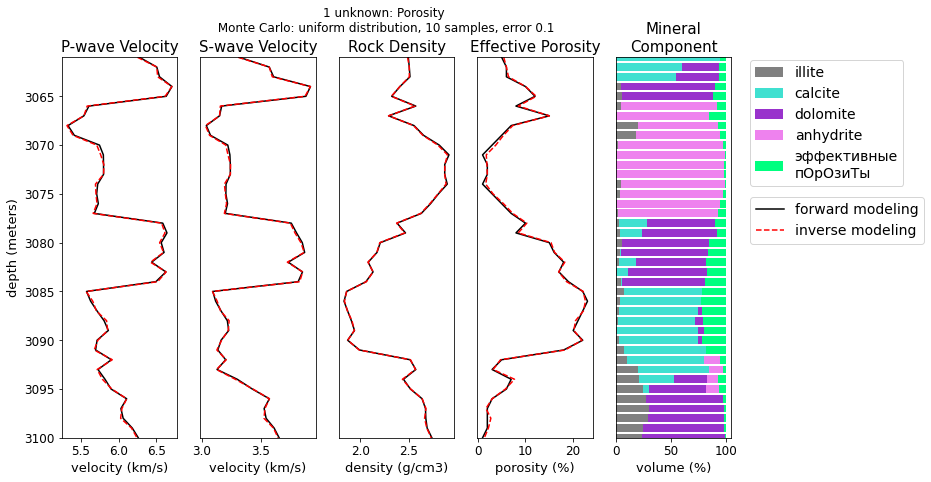

In [159]:
draw_MC_plots(depth, ill, cal, dol, anh, por, all_vp, all_vs, all_rho, all_vp_mc, all_vs_mc, all_rho_mc,
             title = "1 unknown: Porosity \n Monte Carlo: uniform distribution, 10 samples, error 0.1 \n")

In [160]:
# испортим скважину
def spoil_the_well(cal_prop, dol_prop, anh_prop, ill_prop, por_prop, well_error):
    
    cal_prop_err = []
    dol_prop_err = []
    anh_prop_err = []
    ill_prop_err = []
    por_prop_err = []
    
    for i in range(len(cal_prop)):
        cal = cal_prop[i] + np.random.randint(0, well_error)
        dol = dol_prop[i] + np.random.randint(0, well_error)
        anh = anh_prop[i] + np.random.randint(0, well_error)
        ill = ill_prop[i] + np.random.randint(0, well_error)
        por = por_prop[i] + np.random.randint(0, well_error)
        
        all_components = cal + dol + anh + ill + por
        
        
        # нормируем 
        cal = round(cal / all_components * 100)
        dol = round(dol / all_components * 100)
        anh = round(anh / all_components * 100)
        ill = round(ill / all_components * 100)
        por = round(por / all_components * 100)
        
        all_components = cal + dol + anh + ill + por
        
        if all_components == 99:
            cal += 1
        elif all_components ==101:
            por -= 1
            
        cal_prop_err.append(cal)
        dol_prop_err.append(dol)
        anh_prop_err.append(anh)
        ill_prop_err.append(ill)
        por_prop_err.append(por)
        
    return cal_prop_err, dol_prop_err, anh_prop_err, ill_prop_err, por_prop_err

In [161]:
cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 3)

cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, por_prop_10 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 10)

cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, por_prop_15 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 15)

cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, por_prop_20 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 20)

cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, por_prop_30 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 30)

In [162]:
error_0 = [cal_prop, dol_prop, anh_prop, ill_prop, por_prop]
error_3 = [cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3]
error_10 = [cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, por_prop_10]
error_15 = [cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, por_prop_15]
error_20 = [cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, por_prop_20]
error_30 = [cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, por_prop_30]

error_mineral_columns = [error_0, error_3, error_10, error_15, error_20, error_30]

In [163]:
def draw_mineral_columns(error_mineral_columns, depth, title):
    
    fig, axes = plt.subplots(nrows = 1, ncols = len(error_mineral_columns), figsize = (14, 7))
    fig.suptitle(title, fontsize = 18)
    
    
    for i in range(len(error_mineral_columns)):
        error = error_mineral_columns[i]
        
        cal = np.array(error[0])
        dol = np.array(error[1])
        anh = np.array(error[2])
        ill = np.array(error[3])
        por = np.array(error[4])
    
        axes[i].barh(depth, ill, color = 'grey')
        axes[i].barh(depth, cal, color = turquoise, left = ill)
        axes[i].barh(depth, dol, color = dark_violet, left = cal + ill)
        axes[i].barh(depth, anh, color = violet, left = dol + cal + ill)
        axes[i].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
        axes[i].set_ylim(bottom = max(depth), top = min(depth))
        axes[i].yaxis.set_visible(False)
    
    axes[0].yaxis.set_visible(True)
    axes[-1].yaxis.set_visible(True)
    axes[-1].yaxis.tick_right()
    
    
    axes[0].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14,
                   loc = 'upper center', bbox_to_anchor=(3.4, -0.07), fancybox=True, shadow=True, ncol=6)
    
    
    axes[0].set_title('Ideal Well', fontsize = 15)
    axes[1].set_title('3% Error', fontsize = 15)
    axes[2].set_title('10% Error', fontsize = 15)
    axes[3].set_title('15% Error', fontsize = 15)
    axes[4].set_title('20% Error', fontsize = 15)
    axes[5].set_title('30% Error', fontsize = 15)

    fig.tight_layout()

C:\Users\vdvor\AppData\Local\Temp\ipykernel_1756\3218066046.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


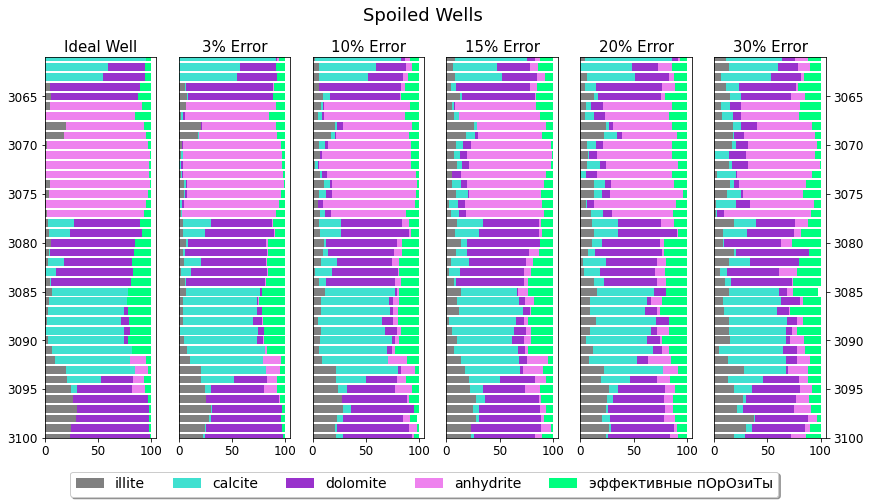

In [164]:
draw_mineral_columns(error_mineral_columns, depth, title = 'Spoiled Wells')

# СТОП 

In [151]:
# решим прямую задачу для всех скважин

all_vp_3, all_vs_3 = get_velocities_in_well(do_forward_problem, cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3)
all_vp_10, all_vs_10 = get_velocities_in_well(do_forward_problem, cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, 
                                              por_prop_10)
all_vp_15, all_vs_15 = get_velocities_in_well(do_forward_problem, cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, 
                                              por_prop_15)
all_vp_20, all_vs_20 = get_velocities_in_well(do_forward_problem, cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, 
                                              por_prop_20)
all_vp_30, all_vs_30 = get_velocities_in_well(do_forward_problem, cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, 
                                              por_prop_30)

error_0 = [np.array(all_vp), np.array(all_vs)]
error_3 = [np.array(all_vp_3), np.array(all_vs_3)]
error_10 = [np.array(all_vp_10), np.array(all_vs_10)]
error_15 = [np.array(all_vp_15), np.array(all_vs_15)]
error_20 = [np.array(all_vp_20), np.array(all_vs_20)]
error_30 = [np.array(all_vp_30), np.array(all_vs_30)]

error_velocities = [error_0, error_3, error_10, error_15, error_20, error_30]

ValueError: too many values to unpack (expected 2)

In [152]:
def draw_velocities_for_spoiled_wells(depth, error_velocities, ill, cal, dol, anh, por):

    ffig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 7))
    #fig.suptitle(title, fontsize = 12)

    # скорость Vp
    axes[0].plot(error_velocities[0][0], depth, c = 'k')
    axes[0].plot(error_velocities[1][0], depth, c = '#87CEFA')
    axes[0].plot(error_velocities[2][0], depth, c = '#1E90FF')
    axes[0].plot(error_velocities[3][0], depth, c = '#0000FF')
    axes[0].plot(error_velocities[4][0], depth, c = '#000080')
    axes[0].plot(error_velocities[5][0], depth, c = '#483D8B')
    
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave Velocity', fontsize = 15)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 13)
    axes[0].set_ylabel('depth (meters)', fontsize = 13)
    axes[0].legend(['ideal', '3% error', '10% error', '15% error', '20% error', '30% error'], fontsize = 14, 
                   bbox_to_anchor=(4.32, 0.7))

    
    # скорость Vs
    axes[1].plot(error_velocities[0][1], depth, c = 'k')
    axes[1].plot(error_velocities[1][1], depth, c = '#87CEFA')
    axes[1].plot(error_velocities[2][1], depth, c = '#1E90FF')
    axes[1].plot(error_velocities[3][1], depth, c = '#0000FF')
    axes[1].plot(error_velocities[4][1], depth, c = '#000080')
    axes[1].plot(error_velocities[5][1], depth, c = '#483D8B')
    
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave Velocity', fontsize = 15)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 13)
    
    
    axes[2].barh(depth, ill, color = 'grey')
    axes[2].barh(depth, cal, color = turquoise, left = ill)
    axes[2].barh(depth, dol, color = dark_violet, left = cal + ill)
    axes[2].barh(depth, anh, color = violet, left = dol + cal + ill)
    axes[2].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14, 
                   bbox_to_anchor=(1.1, 1.01))
    axes[2].yaxis.set_visible(False)
    axes[2].set_title('Mineral Component', fontsize = 15)
    axes[2].set_xlabel('volume (%)', fontsize = 13)

    fig.tight_layout()

In [153]:
draw_velocities_for_spoiled_wells(depth, error_velocities, ill, cal, dol, anh, por)

NameError: name 'error_velocities' is not defined

In [32]:
from time import time

def do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs, N = 100, allowable_error = 0.1):
    
    all_por = []
    
    start = time()
    for i in range(len(well_vp)):
        
        print('отсчет', i)
        
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, 
                        get_moduli_by_SCA, get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                        get_velocity, props, calcite = [70.8, 30.3], dolomite = [80.2, 48.8], 
                        anhydrite = [59.1, 31.4], illite = [25.3, 16.3], water = [2.496, 0], gas = [0.041, 0], 
                        rho_components = [2.71, 2.87, 2.97, 2.52])
        
        avg_por = do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                                 check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true, N, allowable_error)
        
        all_por.append(avg_por)
        
        print()
        print('real_por', porosity)
        print('avg_por', avg_por)
        print()
        
        print("vp true", vp_true)
        vp_final, vs_final = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                                                  get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                                                  get_velocity, props, avg_por)
        print('vp_mc', vp_final)
        print()
        print()
        
    end = time()
    
    return(all_por, end - start)

In [34]:
all_por_3 = [5.05, 5.466666666666666, 4.7, 11.3, 10.5, 8.233333333333334, 15.725, 6.040000000000001, 5.4399999999999995, 3.8, 3.2142857142857144, 2.0714285714285716, 3.05, 1.5142857142857142, 2.1166666666666667, 4.833333333333333, 6.199999999999999, 11.300000000000002, 9.200000000000001, 14.15, 16.15, 16.98, 18.18333333333333, 18.833333333333332, 21.65, 21.42, 21.0, 21.799999999999997, 19.73333333333333, 22.55, 17.45, 5.15, 3.8333333333333335, 8.033333333333333, 6.5, 3.325, 2.125, 1.6000000000000003, 4.6499999999999995, 2.8666666666666667]
all_por_10 = [5.279999999999999, 8.023076923076923, 4.8, 14.37, 16.189999999999998, 6.872727272727274, 13.381818181818181, 7.112500000000001, 3.376923076923077, 2.9000000000000004, 3.0300000000000002, 1.8666666666666665, 5.720000000000001, 7.130769230769231, 8.580000000000002, 10.99090909090909, 11.485714285714286, 7.5, 13.233333333333333, 15.718181818181817, 23.233333333333334, 15.944444444444445, 18.784615384615385, 17.849999999999998, 18.414285714285715, 22.32, 19.75, 19.142857142857146, 21.075, 23.263636363636365, 18.7, 3.2444444444444445, 6.666666666666668, 9.930769230769233, 9.788888888888888, 9.563636363636364, 2.971428571428571, 3.1153846153846154, 7.626666666666667, 9.55]
all_por_15 = [9.5, 7.150000000000001, 3.6142857142857143, 12.400000000000002, 14.1, 10.666666666666666, 12.150000000000002, 5.188235294117646, 12.73, 6.250000000000001, 4.08421052631579, 3.6799999999999997, 6.970000000000001, 9.155555555555557, 7.157142857142857, 10.90625, 13.273333333333333, 9.23846153846154, 15.39, 18.73, 15.5, 15.51, 19.785714285714285, 15.606666666666664, 16.337500000000002, 20.533333333333335, 19.69, 24.025, 19.837500000000002, 21.606666666666666, 22.0, 15.0625, 9.6, 2.606666666666667, 11.772727272727273, 11.99, 4.183333333333334, 3.2299999999999995, 8.328571428571427, 7.992857142857145]
all_por_20 = [13.658333333333333, 14.741666666666665, 7.228571428571429, 12.755555555555555, 16.071428571428573, 16.211111111111112, 15.909090909090908, 3.55625, 5.285714285714286, 2.54, 10.629999999999999, 5.9947368421052625, 3.872727272727273, 6.5, 8.475, 11.825000000000001, 12.387500000000001, 14.177777777777779, 9.31111111111111, 13.719999999999999, 22.589999999999996, 22.75, 19.849999999999998, 17.3, 17.18, 20.8625, 15.75, 23.814285714285717, 13.814285714285711, 19.5, 23.244444444444444, 3.1999999999999997, 2.57, 10.978571428571428, 11.0, 14.47272727272727, 13.049999999999999, 2.575, 14.055555555555557, 3.6142857142857143]
all_por_30 = [11.4125, 10.366666666666667, 13.63, 19.5, 18.527272727272724, 8.793333333333333, 15.942857142857141, 18.07, 19.46153846153846, 7.45, 8.983333333333333, 6.581818181818181, 6.375, 16.607142857142858, 5.094117647058823, 17.859999999999996, 13.673333333333336, 6.674999999999999, 20.455555555555556, 20.199999999999996, 17.57692307692308, 15.788888888888891, 26.575000000000003, 21.3, 20.311111111111114, 19.2375, 15.684615384615386, 12.799999999999999, 16.76153846153846, 22.599999999999998, 23.1, 12.986666666666666, 15.941666666666668, 10.75, 6.575, 2.3874999999999997, 9.200000000000001, 11.76923076923077, 16.525000000000002, 2.5733333333333333]

In [45]:
def draw_porosity_for_spoiled_wells(depth, all_por, all_por_3, all_por_10, all_por_15, all_por_20, all_por_30):

    plt.figure(figsize = (7, 10))
    plt.xlabel('porosity', fontsize = 15)
    plt.ylabel('depth', fontsize = 15)
    plt.title('Effective Porosity', fontsize = 20)
    
    plt.plot(all_por_30, depth, c = '#FF0000')
    plt.plot(all_por_20, depth, c = '#FF9933')
    plt.plot(all_por_15, depth, c = '#FFFF00')
    plt.plot(all_por_10, depth, c = '#99ff33')
    plt.plot(all_por_3, depth, c = '#00CC66')

    plt.plot(all_por, depth, c = 'k', linewidth = 3)
    
    plt.legend(['30% error', '20% error', '15% error', '10% error', '3% error', 'ideal'], fontsize = 15)

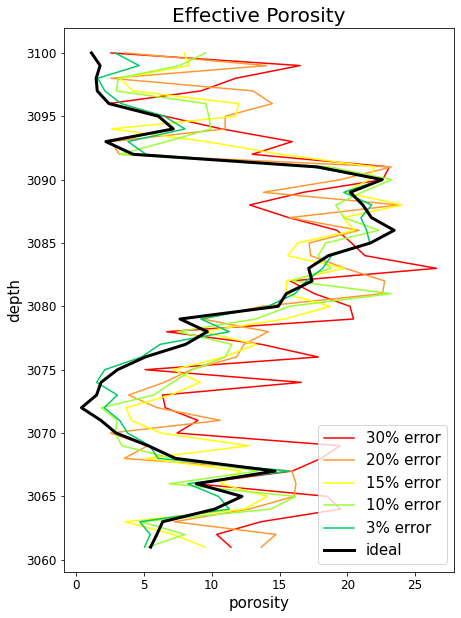

In [46]:
draw_porosity_for_spoiled_wells(depth, all_por, all_por_3, all_por_10, all_por_15, all_por_20, all_por_30)

## Сглаживание кривых 

In [47]:
from scipy.signal import savgol_filter

# Savitzky-Golay filter
def filter_porosity(por, window = 13):
    por_filtered = savgol_filter(por, window, 3)
    return por_filtered

In [48]:
spline_0 = filter_porosity(all_por)
spline_3 = filter_porosity(all_por_3)
spline_10 = filter_porosity(all_por_10)
spline_15 = filter_porosity(all_por_15, window = 17)
spline_20 = filter_porosity(all_por_20, window = 17)
spline_30 = filter_porosity(all_por_30, window = 21)

In [123]:
def draw_filtered_porosity(depth, spline_0, spline_3, spline_10, spline_15, spline_20, spline_30):

    plt.figure(figsize = (7, 10))
    plt.xlabel('porosity', fontsize = 15)
    plt.ylabel('depth', fontsize = 15)
    plt.title('Filtered Effective Porosity', fontsize = 20)
    
    
    plt.plot(spline_30, depth, c = '#FF0000')
    plt.plot(spline_20, depth, c = '#FF9933')
    plt.plot(spline_15, depth, c = '#FFFF00')
    plt.plot(spline_10, depth, c = '#99ff33')
    plt.plot(spline_3, depth, c = '#00CC66')
    
    plt.plot(all_por, depth, c = 'k', linestyle = '--')
    plt.plot(spline_0, depth, c = 'k', linewidth = 3)
    
    
    plt.legend(['30% error', '20% error', '15% error', '10% error', '3% error', 'ideal', 'ideal \nfiltered'], fontsize = 15)

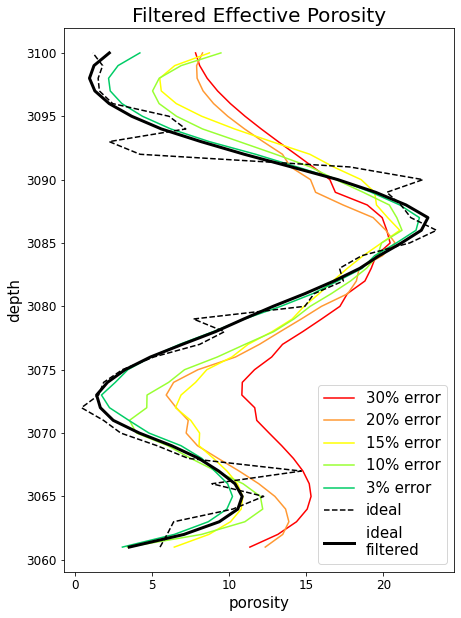

In [124]:
draw_filtered_porosity(depth, spline_0, spline_3, spline_10, spline_15, spline_20, spline_30)

In [164]:
error_3_list = [[5.05, 5.466666666666666, 4.7, 11.3, 10.5, 8.233333333333334, 15.725, 6.040000000000001, 5.4399999999999995, 3.8, 3.2142857142857144, 2.0714285714285716, 3.05, 1.5142857142857142, 2.1166666666666667, 4.833333333333333, 6.199999999999999, 11.300000000000002, 9.200000000000001, 14.15, 16.15, 16.98, 18.18333333333333, 18.833333333333332, 21.65, 21.42, 21.0, 21.799999999999997, 19.73333333333333, 22.55, 17.45, 5.15, 3.8333333333333335, 8.033333333333333, 6.5, 3.325, 2.125, 1.6000000000000003, 4.6499999999999995, 2.8666666666666667], [5.3, 7.35, 6.459999999999999, 8.633333333333331, 11.144444444444444, 9.18, 15.6, 7.459999999999999, 4.22, 3.4599999999999995, 1.2, 3.1999999999999997, 2.42, 3.0999999999999996, 1.3666666666666665, 4.9625, 6.842857142857143, 9.600000000000001, 7.233333333333333, 13.4, 15.566666666666668, 18.766666666666666, 16.85, 17.2, 22.599999999999998, 23.5, 21.900000000000002, 22.0, 18.46666666666667, 20.94, 17.6, 6.5375000000000005, 4.128571428571428, 7.779999999999999, 7.45, 3.5, 1.8166666666666664, 3.65, 3.233333333333333, 1.9333333333333336], [4.933333333333334, 6.5, 8.433333333333335, 10.25, 11.383333333333333, 7.45, 13.133333333333335, 8.075, 6.671428571428571, 2.966666666666667, 2.2666666666666666, 3.2600000000000002, 3.5833333333333335, 2.38, 2.9625, 5.7749999999999995, 8.5, 10.733333333333334, 7.25, 15.757142857142856, 17.099999999999998, 18.057142857142857, 18.1, 17.4, 21.96666666666667, 24.35, 22.750000000000004, 21.0, 18.95, 20.933333333333334, 19.23333333333333, 6.3500000000000005, 4.362500000000001, 6.871428571428572, 6.5, 5.55, 2.7874999999999996, 2.6999999999999997, 2.4, 2.15], [6.7, 5.7, 8.2, 11.316666666666668, 12.940000000000001, 8.075, 15.2, 6.7, 5.459999999999999, 4.8, 2.2, 2.4, 3.233333333333333, 3.6, 1.85, 5.225, 7.1499999999999995, 10.425, 8.9, 15.700000000000001, 16.5, 16.8, 16.075000000000003, 19.5, 20.73333333333333, 22.566666666666666, 20.38, 20.0, 18.37142857142857, 21.549999999999997, 18.75, 4.666666666666666, 3.5000000000000004, 6.833333333333333, 5.157142857142857, 3.2900000000000005, 2.6, 4.025, 3.3, 1.7399999999999998], [5.933333333333333, 5.414285714285714, 8.95, 8.48, 11.633333333333335, 7.125, 15.275, 6.509090909090909, 6.8, 2.716666666666667, 2.1, 2.7199999999999998, 2.52, 3.1699999999999995, 3.6, 5.425000000000001, 7.0, 10.100000000000001, 8.48, 14.200000000000001, 16.033333333333335, 16.2, 16.666666666666668, 17.375, 21.566666666666663, 23.033333333333335, 22.020000000000003, 20.24, 18.599999999999998, 20.1, 17.916666666666668, 6.975, 4.925, 8.533333333333333, 6.85, 2.5, 1.3499999999999999, 1.8199999999999996, 4.071428571428571, 0.5], [6.1, 7.533333333333334, 5.533333333333332, 11.5, 12.349999999999998, 7.942857142857142, 14.575000000000001, 8.42, 7.199999999999999, 2.9999999999999996, 1.4857142857142855, 4.15, 4.3, 2.8300000000000005, 3.8666666666666667, 5.733333333333333, 7.183333333333334, 9.55, 7.633333333333333, 14.8, 16.85, 17.875, 16.799999999999997, 18.733333333333334, 22.2, 21.28571428571429, 21.5, 20.45, 19.5, 20.0, 18.54285714285714, 5.257142857142858, 3.877777777777778, 8.366666666666667, 5.92, 2.4, 1.92, 2.5666666666666664, 2.55, 0.9], [5.739999999999999, 6.942857142857142, 7.533333333333333, 10.479999999999999, 12.142857142857142, 8.622222222222222, 16.0, 7.8, 5.409090909090909, 3.5999999999999996, 2.71, 3.2142857142857144, 2.9, 2.790909090909091, 4.65, 4.8500000000000005, 5.733333333333333, 11.816666666666668, 8.485714285714286, 13.35, 16.349999999999998, 17.1375, 17.72, 17.833333333333332, 21.766666666666666, 22.940000000000005, 21.199999999999996, 19.8, 20.374999999999996, 20.933333333333334, 18.057142857142857, 6.279999999999999, 5.75, 8.614285714285714, 7.571428571428571, 3.577777777777778, 4.033333333333333, 2.2875, 3.3, 1.575], [7.5, 5.65, 5.655555555555556, 10.68, 10.214285714285714, 8.816666666666666, 16.599999999999998, 8.122222222222224, 4.4399999999999995, 2.469230769230769, 3.266666666666666, 2.016666666666667, 3.7666666666666666, 1.6833333333333333, 4.640000000000001, 5.7250000000000005, 9.685714285714285, 8.95, 7.7, 14.966666666666665, 16.455555555555556, 18.3, 16.92, 18.9, 23.025, 23.5, 20.22, 22.75, 20.599999999999998, 21.2, 17.240000000000002, 7.0, 3.7636363636363637, 7.069230769230771, 5.749999999999999, 4.514285714285714, 3.55, 3.5375, 2.8875, 1.98], [5.25, 8.059999999999999, 7.266666666666666, 8.64, 10.9125, 7.855555555555556, 16.327272727272728, 7.1571428571428575, 6.425, 3.0888888888888886, 1.85, 2.85, 3.45, 3.4000000000000004, 3.7142857142857144, 5.409999999999999, 7.8, 9.355555555555556, 8.533333333333333, 15.74, 14.720000000000002, 17.060000000000002, 17.89166666666667, 17.655555555555555, 22.225, 20.9, 20.375, 20.42, 21.12, 21.300000000000004, 18.71666666666667, 5.76, 4.0, 5.65, 7.142857142857143, 6.066666666666666, 1.9499999999999997, 1.7833333333333332, 2.4799999999999995, 2.5], [4.55, 6.466666666666666, 7.039999999999999, 10.86, 12.928571428571429, 9.433333333333332, 14.725000000000001, 7.155555555555556, 5.766666666666667, 3.0999999999999996, 2.4, 3.6399999999999997, 3.6428571428571423, 2.2199999999999998, 4.057142857142857, 6.588888888888888, 7.9875, 9.755555555555556, 7.585714285714286, 14.5, 16.45, 18.657142857142855, 18.428571428571427, 19.633333333333333, 21.9, 20.8, 21.566666666666666, 20.416666666666668, 20.5, 21.833333333333332, 19.22, 4.9799999999999995, 4.033333333333333, 6.95, 6.0249999999999995, 4.949999999999999, 3.5333333333333337, 3.033333333333333, 3.158333333333333, 3.5500000000000007]]
time_3_list = [335.1449296474457, 345.3948965072632, 335.2968578338623, 335.35995650291443, 336.29988718032837, 334.0442159175873, 333.81337451934814, 338.20247316360474, 339.47423815727234, 339.8097641468048]

error_10_list = [[5.279999999999999, 8.023076923076923, 4.8, 14.37, 16.189999999999998, 6.872727272727274, 13.381818181818181, 7.112500000000001, 3.376923076923077, 2.9000000000000004, 3.0300000000000002, 1.8666666666666665, 5.720000000000001, 7.130769230769231, 8.580000000000002, 10.99090909090909, 11.485714285714286, 7.5, 13.233333333333333, 15.718181818181817, 23.233333333333334, 15.944444444444445, 18.784615384615385, 17.849999999999998, 18.414285714285715, 22.32, 19.75, 19.142857142857146, 21.075, 23.263636363636365, 18.7, 3.2444444444444445, 6.666666666666668, 9.930769230769233, 9.788888888888888, 9.563636363636364, 2.971428571428571, 3.1153846153846154, 7.626666666666667, 9.55], [5.577777777777778, 9.239999999999998, 5.390000000000001, 10.663636363636364, 12.999999999999998, 9.96, 15.19090909090909, 10.555555555555555, 7.392857142857143, 9.461538461538463, 2.609090909090909, 6.125, 2.54, 7.088888888888889, 5.574999999999999, 7.754545454545454, 12.244444444444444, 15.836363636363636, 12.0, 13.48, 16.05, 14.385714285714284, 17.83846153846154, 21.88333333333333, 21.24444444444445, 22.1625, 22.816666666666666, 20.78, 20.300000000000004, 22.98333333333333, 22.442857142857143, 6.85, 5.155555555555555, 9.278571428571428, 7.128571428571429, 2.4000000000000004, 7.029999999999999, 6.56153846153846, 6.291666666666667, 7.369999999999999], [6.4375, 9.930769230769231, 11.759999999999998, 10.55, 10.966666666666669, 8.785714285714285, 16.063636363636366, 7.487500000000001, 9.323076923076924, 6.32, 4.742857142857142, 2.04, 7.427272727272728, 2.6444444444444444, 4.981818181818182, 7.32, 11.379999999999999, 12.622222222222224, 5.6375, 12.728571428571428, 15.533333333333331, 17.075, 13.812500000000004, 20.80909090909091, 21.72222222222222, 24.73, 23.616666666666664, 21.666666666666668, 22.814285714285713, 18.428571428571423, 13.319999999999999, 4.722222222222221, 5.2555555555555555, 6.473333333333334, 5.799999999999999, 4.85, 7.82, 3.533333333333333, 7.708333333333335, 3.3999999999999995], [7.909999999999999, 8.818181818181817, 5.488888888888889, 8.440000000000001, 17.625, 11.9, 13.192307692307692, 4.7272727272727275, 5.7749999999999995, 8.7625, 1.72, 5.418181818181818, 6.3999999999999995, 6.06, 9.964285714285714, 8.725, 7.6, 14.918181818181818, 8.38888888888889, 14.477777777777776, 15.0, 20.962500000000002, 12.623076923076924, 21.816666666666666, 22.25, 18.130000000000003, 18.849999999999998, 20.4, 18.875, 21.709090909090907, 14.4, 3.8428571428571425, 4.0375000000000005, 9.171428571428573, 10.34, 3.5222222222222226, 2.85, 4.761538461538462, 6.55, 1.0857142857142856], [7.9799999999999995, 11.955555555555556, 3.6000000000000005, 13.6, 17.10909090909091, 12.625, 19.3, 7.87, 6.644444444444445, 4.25, 2.757142857142857, 5.7727272727272725, 6.241666666666666, 4.85, 3.9, 10.62222222222222, 10.562499999999998, 9.500000000000002, 13.36, 16.666666666666668, 13.462499999999999, 18.08, 13.450000000000003, 18.971428571428568, 21.422222222222228, 21.04285714285714, 24.45, 21.936363636363637, 17.3, 18.86, 19.52857142857143, 11.46, 3.7181818181818183, 8.14, 8.754545454545456, 5.044444444444445, 4.680000000000001, 7.089999999999999, 6.2, 6.477777777777778], [5.208333333333333, 8.575, 7.35, 13.87777777777778, 11.21111111111111, 13.024999999999999, 17.5375, 7.433333333333334, 4.9875, 7.109999999999999, 3.5272727272727264, 4.166666666666667, 6.763636363636365, 3.4444444444444446, 6.261538461538462, 10.442857142857141, 6.528571428571429, 13.449999999999998, 9.0625, 15.887500000000001, 14.58181818181818, 21.166666666666668, 16.64, 21.049999999999997, 20.509999999999998, 20.150000000000002, 17.359999999999996, 20.21111111111111, 20.58888888888889, 26.35, 17.52, 9.18, 8.054545454545453, 7.7777777777777795, 4.300000000000001, 8.379999999999999, 7.822222222222221, 3.388888888888889, 2.35, 3.592857142857142], [5.588888888888889, 7.750000000000002, 9.3125, 10.5, 10.666666666666666, 11.336363636363636, 14.63846153846154, 7.98125, 5.0666666666666655, 7.135714285714285, 3.3818181818181823, 3.3727272727272735, 3.4545454545454546, 3.957142857142857, 5.966666666666668, 4.946153846153846, 7.20625, 11.1625, 13.149999999999999, 14.690000000000001, 19.375, 16.119999999999997, 16.450000000000003, 15.888888888888893, 24.01111111111111, 19.057142857142853, 23.333333333333332, 21.06, 20.25, 21.950000000000003, 14.74, 6.766666666666667, 7.085714285714286, 10.045454545454547, 9.69, 7.9375, 3.516666666666667, 6.733333333333333, 4.275, 6.529999999999999], [6.572727272727272, 7.577777777777778, 6.7125, 10.720000000000002, 15.735714285714284, 8.10909090909091, 14.384615384615385, 6.088235294117648, 7.428571428571429, 4.3, 2.9249999999999994, 4.991666666666666, 7.330000000000001, 4.9, 6.5, 9.299999999999999, 10.899999999999999, 12.100000000000001, 9.583333333333334, 12.000000000000002, 15.325, 19.08, 20.3, 17.639999999999997, 20.583333333333332, 21.0, 24.077777777777776, 23.78, 18.14, 20.95555555555556, 18.644444444444446, 8.169230769230767, 7.336363636363635, 7.953846153846154, 4.878571428571428, 5.978571428571428, 5.246153846153846, 4.114285714285715, 4.828571428571428, 2.1222222222222222], [6.136363636363637, 10.04, 5.5, 13.9, 14.336363636363636, 12.057142857142855, 20.200000000000003, 11.424999999999999, 5.033333333333334, 4.733333333333333, 4.445454545454545, 2.611111111111111, 7.2266666666666675, 5.515384615384614, 5.571428571428572, 4.288235294117647, 6.872727272727274, 10.240000000000002, 6.9, 13.399999999999999, 17.711111111111112, 17.822222222222223, 17.9, 16.914285714285715, 23.387500000000003, 18.23333333333333, 20.979999999999997, 21.33333333333333, 21.287499999999998, 21.07777777777778, 20.400000000000002, 8.6, 8.500000000000002, 9.614285714285714, 12.542857142857143, 5.216666666666667, 7.209999999999999, 6.263636363636363, 2.278571428571429, 2.5], [7.075, 8.32, 12.383333333333335, 10.22, 13.409090909090907, 13.236363636363638, 13.158333333333337, 10.760000000000002, 9.049999999999999, 3.6250000000000004, 4.644444444444445, 2.8272727272727267, 3.246153846153846, 2.95, 8.735714285714286, 4.955555555555555, 7.1000000000000005, 13.342857142857143, 7.724999999999999, 12.17272727272727, 17.919999999999998, 17.5125, 16.3875, 21.685714285714283, 25.27777777777778, 20.28181818181818, 20.55, 20.224999999999998, 17.083333333333332, 18.916666666666668, 18.3625, 8.036363636363637, 4.4, 13.711111111111112, 9.966666666666667, 7.639999999999999, 2.85, 9.860000000000001, 3.5428571428571436, 4.653846153846154]]
time_10_list = [332.2121579647064, 335.88487935066223, 337.0899248123169, 337.31187748908997, 341.4078941345215, 339.02785301208496, 337.65655398368835, 335.12355303764343, 335, 335]

error_15_list = [[9.5, 7.150000000000001, 3.6142857142857143, 12.400000000000002, 14.1, 10.666666666666666, 12.150000000000002, 5.188235294117646, 12.73, 6.250000000000001, 4.08421052631579, 3.6799999999999997, 6.970000000000001, 9.155555555555557, 7.157142857142857, 10.90625, 13.273333333333333, 9.23846153846154, 15.39, 18.73, 15.5, 15.51, 19.785714285714285, 15.606666666666664, 16.337500000000002, 20.533333333333335, 19.69, 24.025, 19.837500000000002, 21.606666666666666, 22.0, 15.0625, 9.6, 2.606666666666667, 11.772727272727273, 11.99, 4.183333333333334, 3.2299999999999995, 8.328571428571427, 7.992857142857145], [4.122222222222222, 13.580000000000002, 10.916666666666666, 12.081818181818182, 9.6, 11.709999999999997, 15.436363636363637, 12.760000000000002, 7.461111111111112, 3.05, 3.8066666666666666, 4.6000000000000005, 3.0916666666666663, 10.694117647058825, 8.46153846153846, 10.26923076923077, 11.58, 12.533333333333331, 13.64, 13.892307692307693, 14.390909090909092, 16.372727272727275, 20.875, 18.96666666666667, 21.571428571428573, 26.642857142857142, 22.172727272727272, 19.869999999999997, 23.799999999999997, 18.82857142857143, 16.822222222222223, 5.722222222222222, 2.3615384615384616, 10.183333333333335, 8.55, 3.0454545454545454, 2.4999999999999996, 5.58, 10.799999999999999, 5.418181818181818], [10.78, 8.566666666666668, 13.533333333333333, 15.02727272727273, 10.38181818181818, 5.8100000000000005, 15.926666666666666, 12.076923076923075, 6.960000000000001, 11.554545454545453, 6.072727272727272, 10.54375, 2.633333333333333, 4.3133333333333335, 5.438461538461538, 5.641176470588235, 15.390909090909092, 9.080000000000002, 14.344444444444443, 14.81818181818182, 14.714285714285714, 21.318181818181817, 19.599999999999998, 19.644444444444442, 21.78888888888889, 19.244444444444444, 16.241666666666667, 18.442857142857143, 22.725, 21.125, 12.3, 5.536363636363635, 10.11, 10.113333333333333, 14.844444444444443, 2.8230769230769233, 7.540000000000001, 2.8625000000000003, 7.666666666666667, 7.990909090909091], [12.355555555555556, 10.600000000000003, 7.866666666666665, 10.25, 10.654545454545454, 12.41666666666667, 16.46, 8.283333333333333, 9.133333333333331, 5.546153846153847, 11.31111111111111, 3.266666666666666, 2.755555555555556, 9.913333333333332, 7.718749999999999, 5.31764705882353, 6.426666666666666, 8.200000000000001, 5.606666666666667, 13.363636363636362, 21.084615384615386, 15.485714285714284, 16.525, 16.87777777777778, 17.34285714285714, 18.9, 16.975, 22.333333333333332, 17.657142857142855, 21.014285714285712, 13.836363636363636, 9.93, 8.82, 9.077777777777776, 10.400000000000002, 3.099999999999999, 6.492857142857142, 9.13076923076923, 7.175, 8.671428571428573], [3.8166666666666664, 7.0357142857142865, 6.763636363636365, 8.03076923076923, 13.846153846153843, 15.73076923076923, 14.070000000000002, 14.028571428571427, 10.333333333333332, 9.011111111111113, 8.327272727272728, 7.923076923076924, 3.7625, 8.04375, 2.19, 10.836363636363636, 13.616666666666667, 9.0625, 9.138461538461538, 22.638461538461538, 24.066666666666663, 19.04, 17.109999999999996, 22.27777777777778, 23.0, 22.729999999999997, 22.74, 16.02857142857143, 16.858333333333334, 24.950000000000003, 13.233333333333333, 12.375, 9.433333333333332, 14.969999999999999, 13.853846153846153, 12.385714285714286, 9.764285714285716, 11.73846153846154, 7.485714285714286, 4.393750000000001], [6.15, 5.2555555555555555, 8.442857142857143, 18.0, 15.207142857142854, 7.446153846153846, 16.163636363636364, 13.508333333333331, 10.639999999999999, 4.608333333333333, 3.0444444444444443, 2.2624999999999997, 8.389473684210525, 2.8444444444444446, 6.675000000000001, 8.2125, 10.235714285714284, 18.7125, 9.213333333333335, 17.42857142857143, 13.963636363636363, 21.233333333333334, 18.157142857142862, 20.740000000000002, 21.43, 24.637499999999996, 26.55, 21.993333333333336, 13.912500000000001, 23.299999999999994, 21.216666666666665, 10.566666666666666, 3.41, 12.549999999999999, 11.054545454545455, 5.541666666666667, 4.04, 2.5, 2.4125, 6.2749999999999995], [6.628571428571428, 10.991666666666667, 9.34, 8.628571428571428, 8.45, 11.486666666666668, 12.714285714285714, 12.415384615384616, 8.183333333333332, 7.644444444444444, 4.0562499999999995, 7.09375, 3.4733333333333336, 5.425, 5.038461538461538, 13.966666666666669, 14.154545454545454, 10.940000000000001, 6.055555555555555, 17.625, 15.2, 17.69, 20.387500000000003, 16.209090909090907, 18.311111111111114, 19.16, 17.242857142857144, 22.74545454545454, 13.488888888888887, 17.979999999999997, 22.13636363636364, 7.758333333333333, 3.469230769230769, 12.990909090909094, 6.721428571428572, 2.253333333333333, 8.731250000000001, 6.854545454545454, 6.363636363636363, 2.9400000000000004], [8.34, 13.183333333333332, 16.325, 7.914285714285714, 14.799999999999999, 14.953846153846154, 13.114285714285716, 5.875000000000001, 5.331250000000001, 6.081250000000001, 7.0699999999999985, 5.141666666666667, 5.477777777777777, 6.246153846153846, 10.9, 5.392307692307693, 10.290909090909091, 10.714285714285714, 6.918181818181819, 14.366666666666667, 14.910000000000002, 20.71666666666667, 17.075000000000003, 22.266666666666666, 19.366666666666664, 22.5, 24.4125, 19.22, 23.014285714285712, 24.38181818181818, 20.74285714285714, 7.327272727272727, 5.0249999999999995, 9.53125, 9.642857142857142, 8.481818181818182, 12.549999999999999, 9.67, 8.681818181818182, 6.130000000000001], [10.999999999999998, 8.363636363636362, 5.3, 13.086666666666668, 15.524999999999999, 7.4923076923076914, 12.646666666666667, 11.314285714285715, 13.392307692307693, 2.685714285714286, 7.0, 10.6, 6.1647058823529415, 9.433333333333334, 6.366666666666667, 9.731249999999998, 7.722222222222224, 10.999999999999998, 11.500000000000002, 11.52, 15.26, 14.646153846153844, 19.2, 19.95, 20.131578947368425, 24.419999999999998, 25.81111111111111, 18.922222222222224, 18.866666666666667, 19.515384615384612, 17.857142857142858, 6.01, 8.022222222222222, 7.711764705882354, 7.718181818181816, 4.680000000000001, 8.04, 8.244444444444445, 7.728571428571428, 2.72], [13.171428571428574, 4.4750000000000005, 5.375, 15.644444444444446, 12.184615384615388, 10.608333333333334, 17.728571428571424, 10.853333333333333, 7.593750000000001, 3.9916666666666667, 3.35, 2.2363636363636363, 6.413333333333335, 4.3933333333333335, 6.566666666666666, 11.972727272727274, 11.816666666666668, 15.725000000000001, 15.399999999999999, 16.853333333333335, 18.985714285714288, 20.725, 19.133333333333333, 16.8875, 16.718181818181815, 18.3, 20.18, 20.674999999999997, 22.357142857142858, 16.77692307692308, 24.700000000000003, 7.061538461538462, 3.0666666666666664, 7.539999999999999, 10.370000000000001, 2.6454545454545455, 7.905555555555556, 2.9, 6.285714285714286, 6.599999999999998]]
time_15_list = [417.21927547454834, 422.42742896080017, 417.33039951324463, 422.36326360702515, 424.07854866981506, 419.8463683128357, 418.07517075538635, 416.23950242996216, 413.72446942329407, 418.27292466163635]

error_20_list = [[13.658333333333333, 14.741666666666665, 7.228571428571429, 12.755555555555555, 16.071428571428573, 16.211111111111112, 15.909090909090908, 3.55625, 5.285714285714286, 2.54, 10.629999999999999, 5.9947368421052625, 3.872727272727273, 6.5, 8.475, 11.825000000000001, 12.387500000000001, 14.177777777777779, 9.31111111111111, 13.719999999999999, 22.589999999999996, 22.75, 19.849999999999998, 17.3, 17.18, 20.8625, 15.75, 23.814285714285717, 13.814285714285711, 19.5, 23.244444444444444, 3.1999999999999997, 2.57, 10.978571428571428, 11.0, 14.47272727272727, 13.049999999999999, 2.575, 14.055555555555557, 3.6142857142857143], [7.5874999999999995, 11.442857142857141, 9.207142857142857, 8.124999999999998, 11.526666666666667, 12.911111111111111, 12.076923076923077, 12.533333333333333, 15.375, 8.4125, 9.799999999999999, 11.753846153846155, 9.038461538461537, 5.84375, 4.973333333333334, 9.408333333333333, 7.355555555555556, 9.184615384615386, 16.090000000000003, 20.47142857142857, 22.4, 15.709999999999999, 12.285714285714286, 24.825, 25.150000000000002, 22.3875, 23.890000000000004, 21.3, 13.26875, 22.033333333333335, 16.8125, 4.746153846153846, 7.812499999999999, 14.491666666666667, 5.241176470588235, 10.766666666666667, 7.1499999999999995, 8.823076923076924, 6.381818181818182, 4.04], [7.20909090909091, 14.439999999999998, 14.841666666666667, 7.315384615384616, 16.3, 16.915384615384617, 18.6, 16.150000000000002, 9.25, 10.016666666666667, 4.959999999999999, 8.944444444444446, 3.7928571428571423, 10.336363636363636, 7.199999999999999, 9.26153846153846, 11.4625, 7.660000000000001, 9.65, 11.400000000000002, 10.91875, 17.13333333333333, 14.657142857142858, 14.70909090909091, 15.91, 24.3, 20.82857142857143, 21.32, 18.74285714285714, 24.928571428571427, 13.677777777777779, 6.777777777777778, 6.35, 4.811111111111111, 7.530769230769229, 10.366666666666667, 14.436363636363637, 7.118181818181818, 4.0874999999999995, 6.933333333333333], [15.084615384615384, 7.26, 7.1125, 20.766666666666666, 10.63, 7.540000000000001, 15.433333333333332, 15.555555555555559, 8.81111111111111, 10.05625, 7.38, 10.847058823529412, 7.557142857142857, 12.133333333333333, 11.116666666666667, 12.646666666666667, 8.528571428571428, 18.25, 12.5, 17.283333333333335, 13.59, 17.88888888888889, 16.916666666666664, 15.408333333333333, 21.150000000000002, 21.662499999999998, 25.990909090909096, 21.177777777777777, 22.486666666666665, 14.275, 18.066666666666666, 6.766666666666667, 3.1799999999999997, 4.4399999999999995, 5.857142857142857, 14.330769230769231, 7.514285714285714, 2.416666666666666, 2.2875, 2.45], [14.855555555555554, 11.85, 11.2375, 11.657142857142858, 18.049999999999997, 16.97272727272727, 12.992307692307692, 6.2125, 8.576190476190478, 6.5266666666666655, 10.946153846153846, 3.6538461538461537, 7.4923076923076914, 3.4999999999999996, 14.01, 5.853846153846154, 19.020000000000003, 13.437499999999998, 10.600000000000001, 15.158333333333333, 18.746153846153852, 13.26, 15.709090909090907, 15.873333333333337, 28.599999999999998, 16.666666666666668, 21.97142857142857, 23.299999999999997, 24.830000000000002, 24.688888888888883, 11.19, 9.036363636363635, 8.663636363636364, 12.338461538461537, 15.320000000000002, 4.127272727272727, 2.6125000000000003, 11.628571428571428, 2.909090909090909, 10.1625], [4.300000000000001, 11.177777777777777, 11.03076923076923, 10.058333333333332, 12.588888888888892, 9.7, 15.516666666666667, 8.161538461538463, 7.476923076923077, 9.536363636363637, 11.193750000000001, 6.5, 10.809090909090909, 10.699999999999998, 9.642857142857142, 10.674999999999999, 7.342857142857142, 13.818181818181818, 8.824999999999998, 18.97692307692308, 13.553333333333335, 16.84166666666667, 15.853333333333333, 13.799999999999999, 16.176923076923078, 22.327272727272728, 14.320000000000002, 27.8, 13.966666666666667, 22.5, 12.9, 10.322222222222223, 9.076923076923077, 13.657142857142857, 7.354545454545454, 5.136842105263158, 3.728571428571428, 11.246153846153845, 8.926666666666668, 6.587500000000002], [13.328571428571427, 10.299999999999999, 6.127272727272728, 6.4, 18.400000000000002, 16.299999999999997, 14.80909090909091, 12.453846153846154, 4.121052631578947, 5.3055555555555545, 2.3714285714285714, 3.400000000000001, 10.2, 11.366666666666667, 5.291666666666667, 4.044444444444444, 12.461538461538462, 11.775, 6.933333333333334, 20.424999999999997, 18.06923076923077, 15.490909090909094, 15.85, 14.593749999999998, 17.733333333333334, 20.139999999999997, 17.1, 24.869230769230764, 21.28571428571428, 19.333333333333332, 15.0, 11.725000000000001, 4.008333333333334, 8.846666666666668, 16.07, 10.2, 10.15, 11.141666666666666, 2.677777777777778, 5.550000000000001], [8.879999999999999, 15.65, 8.174999999999999, 18.48, 12.585714285714285, 10.18888888888889, 15.385714285714284, 12.88125, 9.181249999999999, 7.960000000000001, 9.166666666666666, 10.827272727272726, 14.325000000000003, 10.423076923076923, 11.27, 7.083333333333333, 14.212499999999999, 14.114285714285714, 13.075, 19.823076923076922, 13.233333333333336, 13.141666666666666, 19.977777777777774, 18.814285714285713, 19.8, 25.283333333333335, 19.484615384615385, 20.62222222222222, 22.88571428571429, 15.085714285714285, 17.509090909090908, 11.68888888888889, 5.140000000000001, 12.93888888888889, 9.08421052631579, 13.588888888888889, 10.3625, 9.172222222222222, 5.888888888888888, 14.985714285714284], [10.209090909090909, 8.825, 13.760000000000002, 14.666666666666666, 12.111111111111109, 14.757142857142856, 12.54166666666667, 14.853846153846153, 10.25, 9.549999999999999, 9.492307692307692, 13.071428571428571, 6.874999999999999, 7.764285714285713, 4.322222222222223, 3.7454545454545456, 11.891666666666666, 15.7, 14.792307692307691, 15.258333333333335, 18.83333333333333, 22.259999999999998, 19.369999999999997, 17.1, 21.366666666666667, 23.675, 28.224999999999998, 25.4875, 12.48, 18.907142857142862, 12.81875, 8.685714285714285, 7.531249999999999, 12.476470588235294, 14.77142857142857, 15.322222222222223, 7.95, 6.466666666666666, 3.658333333333333, 12.430000000000001], [12.700000000000001, 13.24, 12.579999999999998, 15.785714285714286, 9.414285714285715, 9.229411764705882, 16.6125, 7.892857142857144, 10.075000000000001, 2.8125, 7.866666666666666, 6.2, 6.720000000000001, 1.8454545454545452, 12.485714285714284, 8.841176470588234, 15.625, 9.0625, 13.5, 16.470000000000002, 21.636363636363633, 18.266666666666666, 24.411111111111108, 14.953846153846156, 23.75714285714286, 25.25, 22.245454545454546, 22.40909090909091, 17.52, 25.9875, 20.8, 7.145454545454546, 12.676923076923076, 14.071428571428571, 14.444444444444445, 3.858333333333333, 6.280000000000001, 8.916666666666668, 10.575, 4.76]]
time_20_list = [419.2092640399933, 425.3130397796631, 416.17191219329834, 417.81922817230225, 416.7734606266022, 420, 425.73402547836304, 425.1300690174103, 417.677059173584, 423.3916645050049]

error_30_list = [[11.4125, 10.366666666666667, 13.63, 19.5, 18.527272727272724, 8.793333333333333, 15.942857142857141, 18.07, 19.46153846153846, 7.45, 8.983333333333333, 6.581818181818181, 6.375, 16.607142857142858, 5.094117647058823, 17.859999999999996, 13.673333333333336, 6.674999999999999, 20.455555555555556, 20.199999999999996, 17.57692307692308, 15.788888888888891, 26.575000000000003, 21.3, 20.311111111111114, 19.2375, 15.684615384615386, 12.799999999999999, 16.76153846153846, 22.599999999999998, 23.1, 12.986666666666666, 15.941666666666668, 10.75, 6.575, 2.3874999999999997, 9.200000000000001, 11.76923076923077, 16.525000000000002, 2.5733333333333333], [4.825, 4.116666666666666, 6.4111111111111105, 17.654545454545453, 20.41, 14.616666666666665, 8.225000000000001, 8.011764705882353, 3.225, 9.6, 2.7999999999999994, 3.192857142857143, 14.580000000000002, 8.384615384615385, 5.704761904761903, 8.155555555555555, 18.025000000000002, 6.866666666666667, 12.06, 19.62727272727273, 10.730000000000002, 11.018181818181818, 13.277777777777779, 16.272727272727273, 22.24, 20.15, 21.91666666666667, 18.96, 13.888235294117647, 15.606666666666671, 14.633333333333333, 11.706249999999999, 9.057142857142859, 14.39, 12.157142857142858, 7.038461538461538, 3.4818181818181815, 4.46923076923077, 6.761538461538461, 3.027272727272728], [3.8444444444444446, 7.569230769230769, 9.654545454545456, 11.919999999999998, 18.118181818181814, 13.86, 13.12857142857143, 7.700000000000002, 11.137500000000001, 5.271428571428571, 16.44, 11.940000000000001, 15.475000000000001, 13.966666666666669, 14.4, 16.153846153846153, 14.288888888888888, 10.852631578947369, 4.564285714285715, 11.116666666666667, 19.520000000000003, 16.21, 18.9, 14.899999999999999, 23.580000000000002, 16.646666666666665, 18.0125, 27.130000000000003, 14.829999999999998, 13.577777777777778, 20.57, 5.3999999999999995, 9.4625, 15.157142857142857, 3.72, 11.923076923076925, 14.199999999999998, 5.3500000000000005, 7.462499999999999, 8.175], [5.3307692307692305, 8.126666666666669, 9.862499999999999, 18.419999999999995, 14.928571428571427, 7.345454545454545, 16.166666666666668, 16.65714285714286, 14.810000000000002, 10.737499999999999, 5.088235294117646, 4.611111111111111, 7.7, 6.036363636363637, 6.871428571428572, 14.355555555555558, 12.409999999999998, 19.857142857142858, 13.170000000000002, 11.46, 15.725000000000001, 12.950000000000001, 15.655555555555553, 15.623076923076923, 12.755555555555556, 27.630000000000003, 24.737500000000004, 19.3875, 26.40909090909091, 22.599999999999998, 13.046153846153846, 12.46923076923077, 17.06, 19.85, 14.400000000000002, 7.880000000000001, 3.3375, 11.353333333333332, 7.733333333333333, 10.666666666666666], [13.85, 8.999999999999998, 12.544444444444444, 18.372727272727275, 18.31, 11.218750000000004, 17.72, 12.4, 10.106666666666667, 6.184210526315791, 7.927272727272728, 13.799999999999999, 7.55294117647059, 10.642857142857142, 5.5, 6.826666666666668, 11.918181818181818, 14.650000000000004, 11.515384615384615, 11.246153846153845, 19.080000000000002, 18.90666666666667, 16.07857142857143, 26.46, 23.076923076923077, 26.3, 16.95, 21.81, 20.254545454545454, 14.814285714285713, 22.119999999999997, 12.881818181818181, 13.572727272727274, 6.9875, 12.018181818181818, 15.79090909090909, 15.0, 3.6538461538461537, 14.633333333333331, 16.366666666666667], [12.925, 16.23333333333333, 11.344444444444445, 16.475, 11.933333333333334, 8.593333333333334, 21.46923076923077, 5.294117647058823, 12.871428571428572, 6.663157894736842, 18.1, 12.627272727272727, 7.67, 12.353333333333332, 8.907692307692308, 8.584615384615386, 11.493333333333336, 21.3, 17.974999999999998, 12.1, 16.525, 21.4, 24.527272727272727, 20.72222222222222, 17.241666666666667, 15.1, 21.288888888888884, 24.990000000000002, 27.71428571428571, 25.488888888888887, 13.749999999999998, 10.750000000000002, 2.1714285714285717, 13.099999999999998, 7.500000000000001, 7.51111111111111, 7.470000000000001, 12.992307692307694, 8.235714285714284, 6.8999999999999995], [9.372727272727273, 8.85, 16.444444444444443, 19.5, 13.872727272727273, 16.625, 12.3375, 8.55, 11.37, 16.36470588235294, 3.7230769230769236, 6.705882352941177, 2.0857142857142854, 17.599999999999998, 14.463636363636361, 20.0, 19.223076923076924, 15.260000000000002, 8.68, 16.241666666666664, 11.557142857142859, 22.6, 23.785714285714285, 19.279999999999998, 17.814285714285713, 27.939999999999998, 19.81111111111111, 13.47272727272727, 17.066666666666666, 15.236363636363636, 21.51, 14.816666666666668, 17.446666666666665, 16.12857142857143, 4.8500000000000005, 7.0600000000000005, 7.671428571428572, 5.1125, 10.876923076923076, 6.659999999999999], [8.36, 13.925, 7.492307692307691, 20.36, 10.466666666666667, 5.75, 17.4, 16.866666666666667, 18.10909090909091, 10.620000000000001, 10.291666666666666, 2.9916666666666667, 14.12142857142857, 13.546666666666665, 10.158333333333331, 10.208333333333336, 8.418181818181818, 10.133333333333333, 16.314285714285713, 11.544444444444444, 20.64, 26.358333333333334, 10.611764705882353, 21.436363636363637, 22.700000000000003, 18.13076923076923, 23.275000000000002, 23.724999999999998, 21.174999999999997, 23.0, 10.52142857142857, 7.4, 5.142857142857143, 19.253333333333334, 15.475, 14.928571428571429, 8.873333333333333, 6.1375, 7.025, 5.425], [17.181818181818183, 5.499999999999999, 13.476923076923079, 9.1, 25.633333333333336, 3.8285714285714287, 13.85, 7.88, 6.869230769230769, 3.466666666666667, 4.933333333333334, 12.808333333333332, 2.5714285714285716, 5.3136363636363635, 12.649999999999999, 11.181250000000002, 7.645454545454545, 13.207142857142857, 18.237499999999997, 15.063636363636363, 9.069230769230769, 18.733333333333334, 28.075000000000003, 22.6, 20.95, 21.014285714285712, 19.557142857142853, 25.61428571428571, 18.678571428571427, 18.218181818181815, 26.045454545454547, 6.206666666666665, 10.969999999999999, 12.34, 16.28181818181818, 12.964285714285714, 3.146153846153846, 6.611111111111111, 14.115384615384615, 7.48125], [11.274999999999999, 5.418181818181818, 10.96, 6.5875, 14.992857142857142, 10.941666666666668, 19.355555555555558, 9.7, 5.235714285714287, 10.00666666666667, 11.071428571428571, 7.849999999999999, 2.016666666666666, 4.083333333333333, 14.4, 8.63076923076923, 9.19, 19.0375, 10.280000000000001, 18.55, 17.007692307692306, 26.0, 14.366666666666665, 19.433333333333334, 17.923076923076927, 21.71666666666667, 22.425, 17.608333333333334, 17.48888888888889, 25.5375, 22.34166666666667, 17.96666666666667, 5.099999999999999, 14.175, 8.685714285714285, 2.6866666666666665, 15.036363636363637, 11.533333333333335, 14.98, 12.449999999999998]]
time_30_list = [415.8529648780823, 430.29755449295044, 421.7887132167816, 425.2516143321991, 424.87238240242004, 420.21395230293274, 421.6739728450775, 849.9779634475708, 422.50440669059753, 485.4765923023224]

In [165]:
error_3_filtered = []
error_10_filtered = []
error_15_filtered = []
error_20_filtered = []
error_30_filtered = []
    
for i in range(len(error_3_list)):
    sample_3 = filter_porosity(error_3_list[i])
    error_3_filtered.append(sample_3)
    
    sample_10 = filter_porosity(error_10_list[i])
    error_10_filtered.append(sample_10)
    
    sample_15 = filter_porosity(error_15_list[i])
    error_15_filtered.append(sample_15)
    
    sample_20 = filter_porosity(error_20_list[i])
    error_20_filtered.append(sample_20)
    
    sample_30 = filter_porosity(error_30_list[i])
    error_30_filtered.append(sample_30)

In [166]:
def get_loss(ideal_l, non_ideal_l):
    ideal = np.array(ideal_l)
    non_ideal = np.array(non_ideal_l)
    
    return np.sum((ideal - non_ideal)**2)

In [167]:
error_3_losses = []
error_10_losses = []
error_15_losses = []
error_20_losses = []
error_30_losses = []

for i in range(len(error_10_filtered)):
    error_3_losses.append(get_loss(spline_0, error_3_filtered[i]))
    error_10_losses.append(get_loss(spline_0, error_10_filtered[i]))
    error_15_losses.append(get_loss(spline_0, error_15_filtered[i]))
    error_20_losses.append(get_loss(spline_0, error_20_filtered[i]))
    error_30_losses.append(get_loss(spline_0, error_30_filtered[i]))
    
losses = [error_3_losses, error_10_losses, error_15_losses, error_20_losses, error_30_losses]

In [168]:
error_loss_mead_3 = sum(error_3_losses)/len(error_3_losses)
error_loss_mead_10 = sum(error_10_losses)/len(error_10_losses)
error_loss_mead_15 = sum(error_15_losses)/len(error_15_losses)
error_loss_mead_20 = sum(error_20_losses)/len(error_20_losses)
error_loss_mead_30 = sum(error_30_losses)/len(error_30_losses)

meads = [error_loss_mead_3, error_loss_mead_10, error_loss_mead_15, error_loss_mead_20, error_loss_mead_30]

In [169]:
print(error_loss_mead_3, error_loss_mead_10, error_loss_mead_15, error_loss_mead_20, error_loss_mead_30)

23.258715938690933 220.61338310331786 443.753102826248 751.1433719967354 1087.2870089210307


In [170]:
errors_all = ['3%', '10%', '15%', '20%', '30%']
errors_10 = ['№1', '№2', '№3', '№4', '№5', '№6', '№7', '№8', '№9', '№10']

numbers = []
for i in range(10):
    numbers.append(str(i + 1))

In [171]:
time_3 = []
time_10 = []
time_15 = []
time_20 = []
time_30 = []


for i in range(10):
    time_3.append(round(time_3_list[i], 2))
    time_10.append(round(time_10_list[i], 2))
    time_15.append(round(time_15_list[i], 2))
    time_20.append(round(time_20_list[i], 2))
    time_30.append(round(time_30_list[i], 2))
    
time = [time_3, time_10, time_15, time_20, time_30]
print(time)


time_avg = []

time_3_avg = round(sum(time_3_list)/10, 2)
time_10_avg = round(sum(time_10_list)/10, 2)
time_15_avg = round(sum(time_15_list)/10, 2)
time_20_avg = round(sum(time_20_list)/10, 2)
time_30_avg = round(sum(time_30_list)/10, 2)

time_avg = [time_3_avg, time_10_avg, time_15_avg, time_20_avg, time_30_avg]
print(time_avg)

[[335.14, 345.39, 335.3, 335.36, 336.3, 334.04, 333.81, 338.2, 339.47, 339.81], [332.21, 335.88, 337.09, 337.31, 341.41, 339.03, 337.66, 335.12, 335, 335], [417.22, 422.43, 417.33, 422.36, 424.08, 419.85, 418.08, 416.24, 413.72, 418.27], [419.21, 425.31, 416.17, 417.82, 416.77, 420, 425.73, 425.13, 417.68, 423.39], [415.85, 430.3, 421.79, 425.25, 424.87, 420.21, 421.67, 849.98, 422.5, 485.48]]
[337.28, 336.57, 418.96, 420.72, 471.79]


In [172]:
def draw_error_bar_plots(losses, meads, time, time_avg, numbers):
    
    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (7, 14))
    #fig.suptitle(title, fontsize = 18)
    
    for i in range(len(losses)):
        axes[i].bar(numbers, losses[i], color ='maroon', width = 0.4)
        axes[i].bar('average', meads[i], color = 'r', width = 0.4)  
        
        axes[i].set_xlabel("Error Percent", fontsize = 13)
        axes[i].set_ylabel("Loss", fontsize = 13)
        
    axes[0].set_title('3% Error, time {} (s)'.format(str(time_avg[0])), fontsize = 15)
    axes[1].set_title('10% Error, time {} (s)'.format(str(time_avg[1])), fontsize = 15)
    axes[2].set_title('15% Error, time {} (s)'.format(str(time_avg[2])), fontsize = 15)
    axes[3].set_title('20% Error, time {} (s))'.format(str(time_avg[3])), fontsize = 15)
    axes[4].set_title('30% Error, time {}'.format(str(time_avg[4])), fontsize = 15)
                             

    fig.tight_layout()

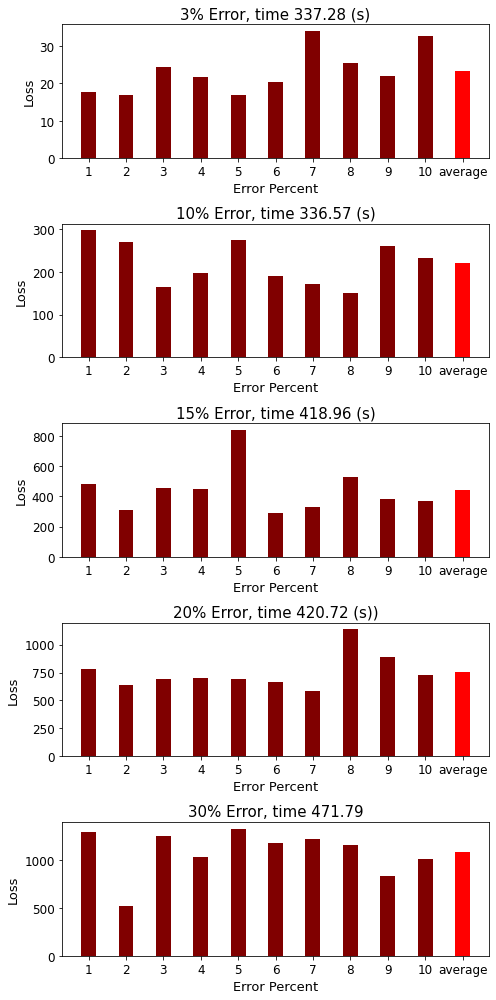

In [173]:
draw_error_bar_plots(losses, meads, time, time_avg, numbers)

In [177]:
def draw_final_bar_plot(errors_all, meads):
    
    plt.figure(figsize = (10, 6))
    
    plt.bar(errors_all, meads, color ='maroon', width = 0.5)
 
    plt.xlabel("Error Percent", fontsize = 13)
    plt.ylabel("Loss", fontsize = 13)

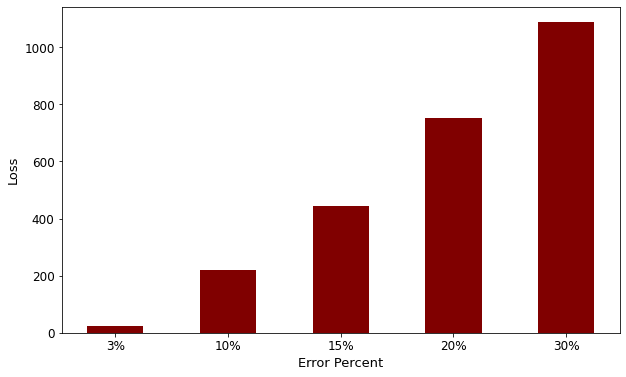

In [178]:
draw_final_bar_plot(errors_all, meads)